# Projet SY09 - Bigfoot

A faire :
* ajouter de Laura : carte, ACP et CAH + visualisations multivariées
* ? rempalcer abbréviation du mois par numéro de mois
* Remplacer les valeurs manquantes et refaire des étapes si besoin
* Ajouter des unités aux graphiques
* parler en pourcentage

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg

from datetime import datetime
from calendar import month_abbr, month_abbr

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from rake_nltk import Rake

%matplotlib inline

## Chargement du jeu de données

In [2]:
# importer données du fichier csv

bigfoot = pd.read_csv("data/bigfoot.csv", sep = ",")
bigfoot

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,moon_phase,precip_intensity,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed
0,I was canoeing on the Sipsey river in Alabama....,NaN,Winston County,Alabama,Summer,NaN,NaN,NaN,NaN,30680.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ed L. was salmon fishing with a companion in P...,East side of Prince William Sound,Valdez-Chitina-Whittier County,Alaska,Fall,NaN,NaN,NaN,NaN,1261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"While attending U.R.I in the Fall of 1974,I wo...","Great swamp area, Narragansett Indians",Washington County,Rhode Island,Fall,Report 6496: Bicycling student has night encou...,41.45,-71.5,1974-09-20,6496.0,...,0.16,0.0,0.0,NaN,1020.61,Foggy until afternoon.,4.0,2.75,198.0,6.92
3,"Hello, My name is Doug and though I am very re...",I would rather not have exact location (listin...,York County,Pennsylvania,Summer,NaN,NaN,NaN,NaN,8000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,It was May 1984. Two friends and I were up in ...,"Logging roads north west of Yamhill, OR, about...",Yamhill County,Oregon,Spring,NaN,NaN,NaN,NaN,703.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,while camping protecting other equipment befor...,(withheld),Rio Arriba County,New Mexico,Summer,NaN,NaN,NaN,NaN,11992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017,I was on my way to work on a Saturday morning ...,"Laurel, Maryland. It was sighted off of Rt 19...",Prince George's County,Maryland,Spring,NaN,NaN,NaN,NaN,1171.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5018,On the twenty sixth and again on the twenty se...,"head n.on highway 441 from Orlando,then go eas...",Lake County,Florida,Summer,NaN,NaN,NaN,NaN,30267.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5019,I was hunting on me and my neighbor's property...,It was on my neighbor's property in the woods ...,White County,Illinois,Fall,NaN,NaN,NaN,NaN,59058.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# informations avant traitements

bigfoot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   observed            4983 non-null   object 
 1   location_details    4261 non-null   object 
 2   county              5021 non-null   object 
 3   state               5021 non-null   object 
 4   season              5021 non-null   object 
 5   title               4045 non-null   object 
 6   latitude            4045 non-null   float64
 7   longitude           4045 non-null   float64
 8   date                4045 non-null   object 
 9   number              5021 non-null   float64
 10  classification      5021 non-null   object 
 11  geohash             4045 non-null   object 
 12  temperature_high    3338 non-null   float64
 13  temperature_mid     3186 non-null   float64
 14  temperature_low     3189 non-null   float64
 15  dew_point           3373 non-null   float64
 16  humidi

On a donc les informations suivantes :

| Variables          | Description                                                                                                                                                                                                                                                                                            |
|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| observed           | Témoignage textuel.                                                                                                                                                                                                                                                                                    |
| location_details   | Texte détaillant le lieu où le bigfoot aurait été repéré.                                                                                                                                                                                                                                              |
| county             | Comté. Division plus petite qu'un état mais plus grand qu'une ville.                                                                                                                                                                                                                                   |
| state              | Etat des Etats-Unis.                                                                                                                                                                                                                                                                                   |
| season             | Les 4 saisons.                                                                                                                                                                                                                                                                                         |
| title              | Format “Report [numéro] : [titre]”                                                                                                                                                                                                                                                                     |
| latitude           | Latitude (localisation géographique).                                                                                                                                                                                                                                                                  |
| longitude          | Longitude (localisation géographique).                                                                                                                                                                                                                                                                 |
| date               | Date (donnée temporelle).                                                                                                                                                                                                                                                                              |
| number             | Numéro de rapport.                                                                                                                                                                                                                                                                                     |
| classification     | 3 valeurs possibles : “Class A”, “Class B”, “Class C”. Class A : a croisé le Bigfoot sans erreur d'interprétation. Class B : a possiblement croisé le Bigfoot. Class C : témoignage de faible fiabilité, peu de sources (pris en compte car fort potentiel que ces personnes n'aient pas vu le big foot) |
| geohash            | Redondance avec les variables latitude et longitude.                                                                                                                                                                                                                                                   |
| temperature_high   | Température haute.                                                                                                                                                                                                                                                                                     |
| temperature_mid    | Température moyenne.                                                                                                                                                                                                                                                                                   |
| temperature_low    | Température basse.                                                                                                                                                                                                                                                                                     |
| dew_point          | Point de rosée. Est une température. Se détermine en fonction de la température et de l'humidité.                                                                                                                                                                                                                                                                |
| humidity           | Taux d'humidité.                                                                                                                                                                                                                                                                                       |
| cloud_cover        | Taux de couverture nuageuse.                                                                                                                                                                                                                                                                           |
| moon_phase         | Phase de la lune telle que : 0 à 0.25 pour le 1er croissant, 0.25 pour le 1er quartier, 0.25 à 0.5 pour la lune gibbeuse croissante, 0.5 pour la pleine lune, 0.5 à 0.75 pour la lune gibbeuse décroissante, 0.75 pour le dernier quartier et 0.75 à 1 pour le dernier croissant.                                                                  |
| precip_intensity   | Intensité de la pluie en hauteur d'eau tombée sur le sol.                                                                                                                                                                                                                                              |
| precip_probability | Probabilité de pluie.                                                                                                                                                                                                                                                                                  |
| precip_type        | Type de précipitation.                                                                                                                                                                                                                                                                                 |
| pressure           | Pression atmosphérique.                                                                                                                                                                                                                                                                                |
| summary            | Texte résumant les conditions météorologiques.                                                                                                                                                                                                                                                         |
| uv_index           | Indice UV.                                                                                                                                                                                                                                                                                             |
| visibility         | Visibilité. Est une distance.                                                                                                                                                                                                                                                                          |
| wind_bearing       | Différent de la direction du vent. Représente la direction vers laquelle un objet est déplacé par le vent.                                                                                                                                                                                             |
| wind_speed         | Vitesse du vent.                                                                                                                                                                                                                                                                                       |

A noter que le climat change d'un état à un autre. En floride il fait plus chaud que dans le nord du pays.

### Mise en forme du jeu de données
#### Ajout et suppression de colonnes

In [4]:
# ajoute des colonnes jour, mois, année
# A faire avant que "date" ne soit convertie au format datetime64[ns]

year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in range(bigfoot['date'].size):
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = datetime.strptime(str(d_datetime.month), "%m").strftime("%b") # nom abbrégé du mois
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# suppression de la colonne "geohash"

bigfoot.drop(columns="geohash", inplace=True)

#### Conversion d'unité et mise en forme des données

In [5]:
# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius

# wind_speed : miles par heure en kilomètre par heure

# precip_intensity : inch en cm

# visibility : miles en kilomètre

bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    
    wind_speed = bigfoot.wind_speed * 1.609344,
    
    precip_intensity = bigfoot.precip_intensity * 2.54,
    
    visibility = bigfoot.visibility * 1.609344
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”

bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

/tmp/ipykernel_10718/1321290715.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


#### Conversion des types

In [6]:
# liste des états des Etats-Unis

states = [
    "Alabama",
    "Alaska",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "Florida",
    "Georgia",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "North Dakota",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Vermont",
    "Virginia",
    "Washington",
    "West Virginia",
    "Wisconsin",
    "Wyoming"
]

# Liste des mois en abbrégé

months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",        
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec"]

In [7]:
# variables catégorielles

# county
bigfoot.county = pd.Categorical(bigfoot.county)

# state
bigfoot.state = pd.Categorical(bigfoot.state, categories=states)

# season
bigfoot.season = bigfoot.season.replace("Unknown", np.nan)
bigfoot.season = pd.Categorical(bigfoot.season, categories=["Winter", "Spring", "Summer", "Fall"], ordered=True)

# classification
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = bigfoot.classification.replace("Class C", "C")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B", "C"], ordered=True)

# precip_type
bigfoot.precip_type = pd.Categorical(bigfoot.precip_type, categories=["rain", "snow"])

# mois
bigfoot.month = pd.Categorical(bigfoot.month, categories=months, ordered=True)

In [8]:
# types des variables

# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.

bigfoot.observed = bigfoot.observed.astype('string')
bigfoot.location_details = bigfoot.location_details.astype('string')
bigfoot.title = bigfoot.title.astype('string')
bigfoot.summary = bigfoot.summary.astype('string')


bigfoot.uv_index = bigfoot.uv_index.astype('Int64')
bigfoot.number = bigfoot.number.astype('Int64')

bigfoot.day = bigfoot.day.astype('Int64')
bigfoot.month = bigfoot.month.astype('string')
bigfoot.year = bigfoot.year.astype('Int64')

# Attention! Conséquence, date a des valeurs NaT à la place de NaN.
bigfoot.date = bigfoot.date.astype("datetime64[ns]")

In [9]:
# vérification des modifications

bigfoot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   observed            4983 non-null   string        
 1   location_details    4261 non-null   string        
 2   county              5021 non-null   category      
 3   state               5021 non-null   category      
 4   season              4929 non-null   category      
 5   title               4045 non-null   string        
 6   latitude            4045 non-null   float64       
 7   longitude           4045 non-null   float64       
 8   date                4045 non-null   datetime64[ns]
 9   number              5021 non-null   Int64         
 10  classification      5021 non-null   category      
 11  temperature_high    3338 non-null   float64       
 12  temperature_mid     3186 non-null   float64       
 13  temperature_low     3189 non-null   float64     

In [10]:
# vérification des modifications

# bigfoot

#### Sauvegarder le jeu de données mis en forme

In [11]:
# attention : si utilisé par la suite, refaire toute les manipulations de changement de type car bigfoot.info() ne renverra pas ce qui a été obtenu juste avant

bigfoot.to_csv("data/bigfoot_after_manipulation.csv", index=False)

## Exploration des données

### Exploration univariée

In [12]:
# valeurs toujours indiquées : county, state, season, number, classification
# quasiment toujours données : observed, location_details
# quasiment toujours données (ensemble): title, longitude, latitude, date (donc day, month, year)

total = bigfoot.isna().sum().sort_values(ascending=False)
percent = (bigfoot.isna().sum()/bigfoot.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
precip_type,3298,0.656841
pressure,2402,0.478391
precip_probability,2311,0.460267
precip_intensity,2309,0.459869
visibility,1972,0.392750
cloud_cover,1937,0.385780
temperature_mid,1835,0.365465
temperature_low,1832,0.364868
temperature_high,1683,0.335192
summary,1655,0.329616


In [13]:
# variables numériques

bigfoot.describe()

,latitude,longitude,number,temperature_high,temperature_mid,temperature_low,dew_point,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,uv_index,visibility,wind_bearing,wind_speed,year,day
count,4045.000000,4045.000000,5021.0,3338.000000,3186.000000,3189.000000,3373.000000,3373.000000,3084.000000,3396.000000,2712.000000,2710.000000,2619.000000,3392.0,3049.000000,3387.000000,3389.000000,4045.0,4045.0
mean,39.363271,-97.423304,21520.234814,19.509830,14.357432,9.243760,7.907463,0.705672,0.438982,0.497968,0.014499,0.295771,1017.081184,5.161262,13.667267,196.572483,6.221855,1998.917429,14.344623
std,5.684022,16.727556,19259.146267,9.879105,9.109215,8.857676,9.135823,0.160626,0.332981,0.288318,0.127324,0.418053,6.144359,3.136283,3.315492,96.375443,5.285835,14.628472,8.583989
min,25.141000,-167.131000,60.0,-18.122222,-22.475000,-30.433333,-24.005556,0.080000,0.000000,0.000000,0.000000,0.000000,980.340000,0.0,1.190915,0.000000,0.000000,1869.0,1.0
25%,35.345720,-117.057900,4595.0,12.855556,8.204167,3.055556,1.538889,0.620000,0.120000,0.250000,0.000000,0.000000,1013.420000,3.0,12.327575,128.000000,2.156521,1990.0,8.0
50%,39.304500,-91.767330,15473.0,21.097222,15.200000,9.666667,8.161111,0.730000,0.400000,0.490000,0.000000,0.000000,1016.960000,5.0,15.209910,203.000000,4.715378,2003.0,15.0
75%,43.931100,-83.069770,33979.0,27.275000,21.322222,15.922222,15.000000,0.820000,0.730000,0.750000,0.003810,0.730000,1020.635000,8.0,16.093440,273.000000,8.947953,2009.0,20.0
max,64.891390,-68.228300,71997.0,41.394444,34.461111,29.077778,25.222222,1.000000,1.000000,1.000000,5.255260,1.000000,1042.410000,13.0,16.093440,359.000000,38.527695,2021.0,31.0


On remarque que :
* Les températures sont tempérées. Les médianes pour les température basses, moyennes et élevées sont de 9,7°C, 15,2°C et de 21°C.
* Le taux d'humidité pour le premier quartile est à 62%, la médiane à 73% et le troisième quartile à 82%. D'après http://www.usa.com/rank/us--average-humidity--state-rank.htm , l'état avec l'humidité moyenne la plus basse prend une valeur de 71% et la plus haute à 82%. 
* Il y a peu de précipitations et si il y en a elle est de faible intensité.

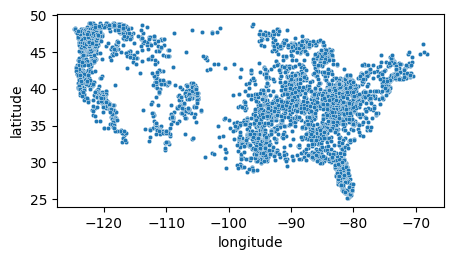

In [14]:
# longitude > -130 donc enlève Alaska et 3 autres points

plt.figure(figsize=(5,2.5))
sns.scatterplot(x=bigfoot['longitude'][bigfoot['longitude'] > -130], y='latitude', s=10, data=bigfoot)
plt.show()

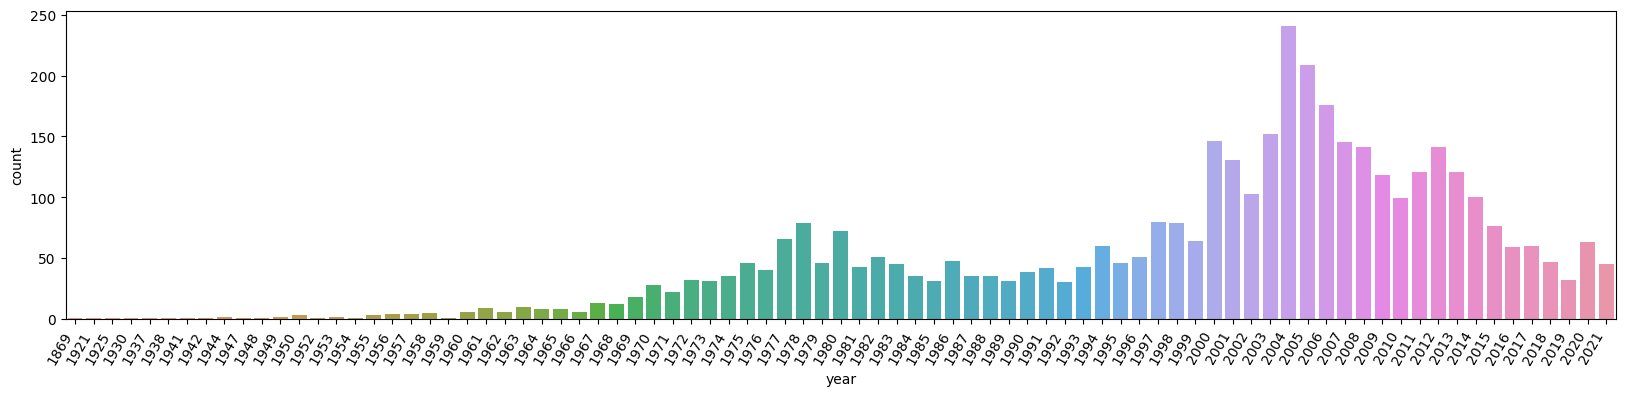

In [15]:
# Les témoignages remontent à 1869 mais commencent à être notables dans les années 1960,puis une tendance vers la fin des années 70 et début des années 80.
# Puis un léger déclin. Dans les années 90 il y eut un net engouement jusqu'à 2004, 
# l'année avec le plus de témoignages et s'ensuit un déclin jusqu'à de nos jours en 2021.

plt.figure(figsize=(20,4))
ax = sns.countplot(x=bigfoot.year[bigfoot.year != np.NaN])
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.show()

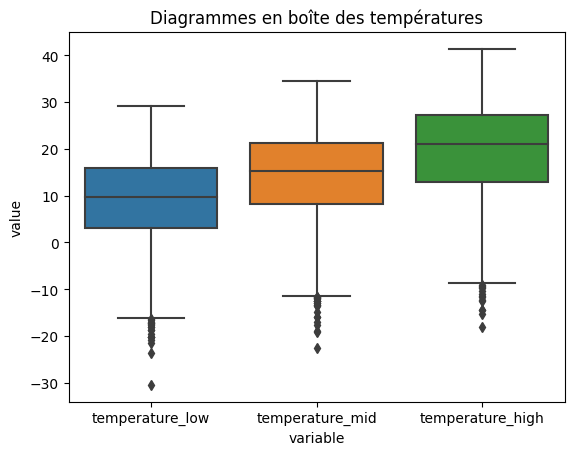

In [16]:
df = pd.DataFrame(data=bigfoot, columns=["temperature_low", "temperature_mid", "temperature_high"])
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title("Diagrammes en boîte des températures")
plt.show()

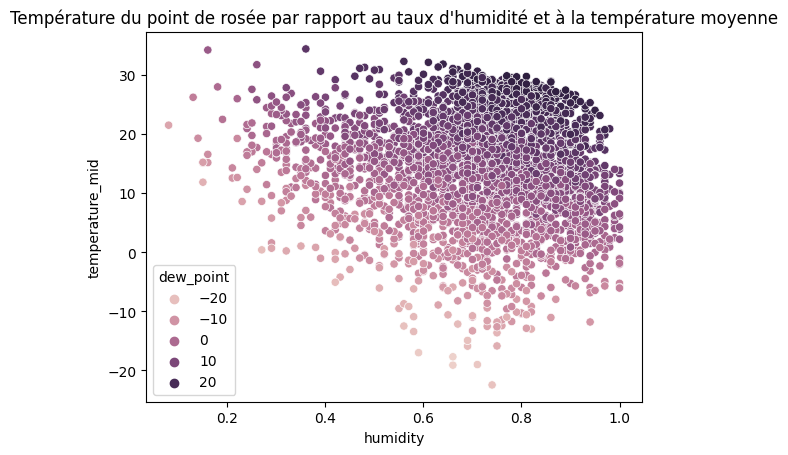

In [17]:
# pour montrer que "dew_point" dépend de "humidity" et de "temperature"

sns.scatterplot(x="humidity", y= "temperature_mid", hue = "dew_point", data = bigfoot)
plt.title("Température du point de rosée par rapport au taux d'humidité et à la température moyenne")
plt.show()

<AxesSubplot: title={'center': 'wind_speed'}, xlabel='wind_speed'>

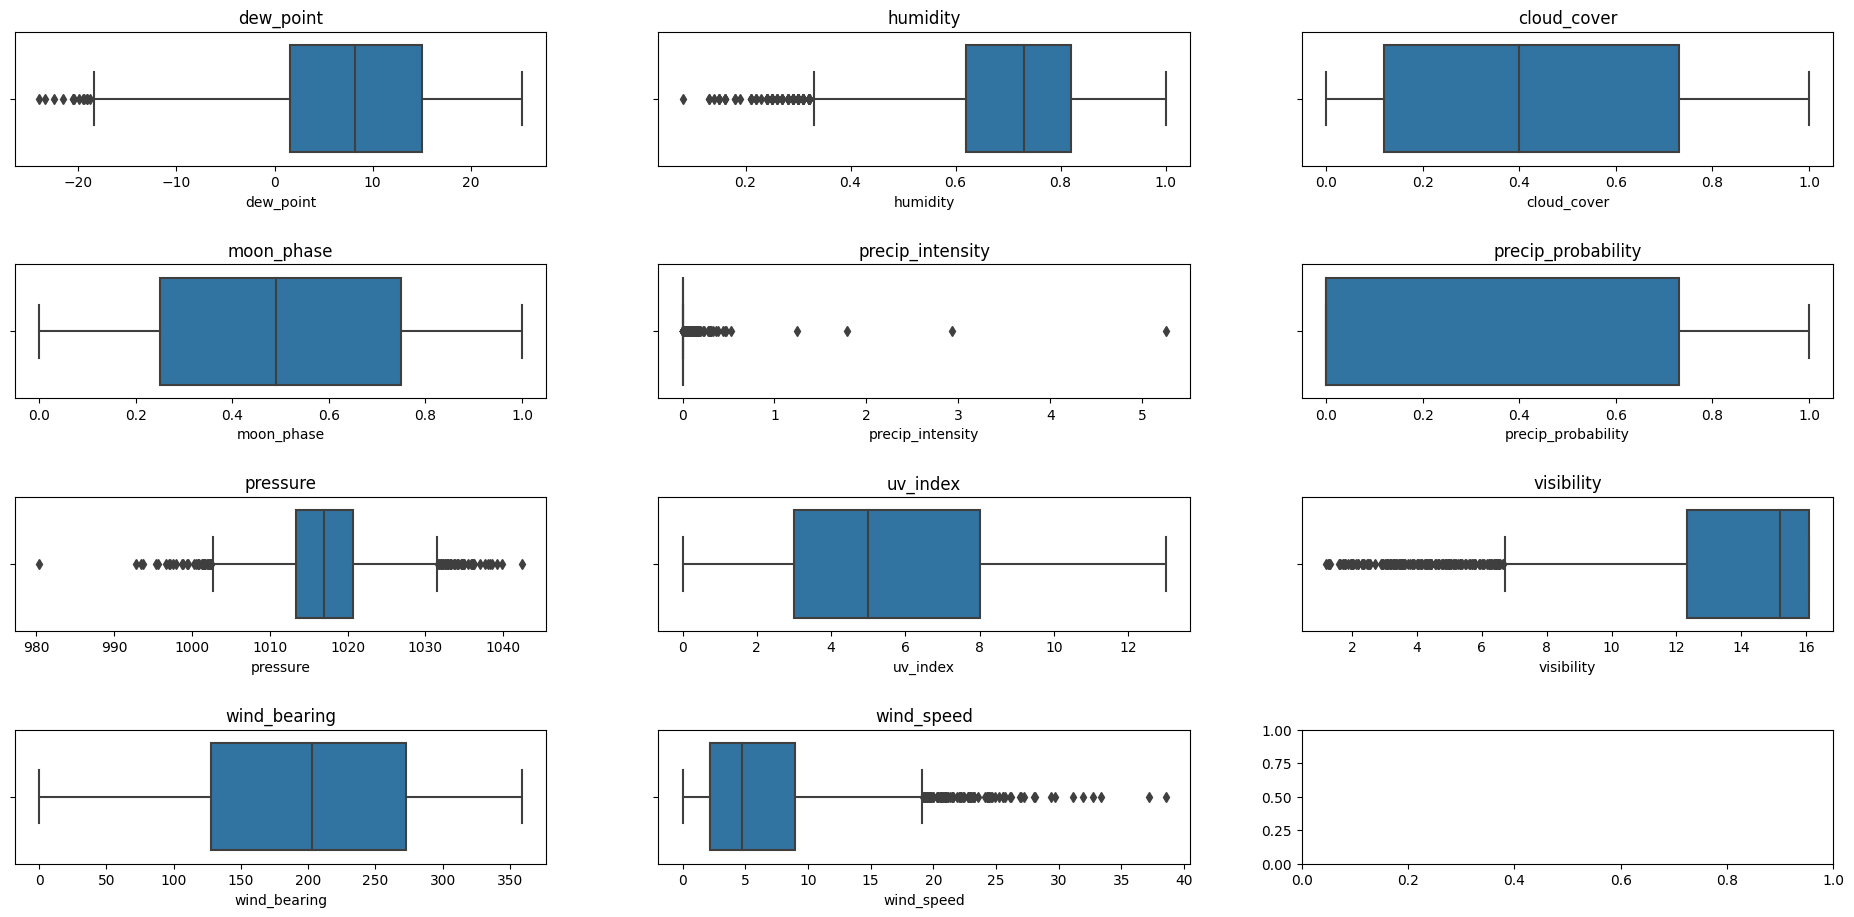

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

axes[0, 0].set_title("dew_point")
sns.boxplot(ax=axes[0, 0], x="dew_point", data = bigfoot)

axes[0, 1].set_title("humidity")
sns.boxplot(ax=axes[0, 1], x="humidity", data = bigfoot)

axes[0, 2].set_title("cloud_cover")
sns.boxplot(ax=axes[0, 2], x="cloud_cover", data = bigfoot)

axes[1, 0].set_title("moon_phase")
sns.boxplot(ax=axes[1, 0], x="moon_phase", data = bigfoot)

axes[1, 1].set_title("precip_intensity")
sns.boxplot(ax=axes[1, 1], x="precip_intensity", data = bigfoot)

axes[1, 2].set_title("precip_probability")
sns.boxplot(ax=axes[1, 2], x="precip_probability", data = bigfoot)

axes[2, 0].set_title("pressure")
sns.boxplot(ax=axes[2, 0], x="pressure", data = bigfoot)

axes[2, 1].set_title("uv_index")
sns.boxplot(ax=axes[2, 1], x="uv_index", data = bigfoot)

axes[2, 2].set_title("visibility")
sns.boxplot(ax=axes[2, 2], x="visibility", data = bigfoot)

axes[3, 0].set_title("wind_bearing")
sns.boxplot(ax=axes[3, 0], x="wind_bearing", data = bigfoot)

axes[3, 1].set_title("wind_speed")
sns.boxplot(ax=axes[3, 1], x="wind_speed", data = bigfoot)


On remarque que : 
* Confirmation que s'il y a des précipitations, celles-ci sont généralement très faibles.
* L'index uv est moyen, avec une tendance avec des valeurs faibles à moyenne.

Ci-dessous, des comparaisons entre diagrammes en boîte et histogramme pour une meilleure interprétation.

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='cloud_cover', ylabel='Count'>

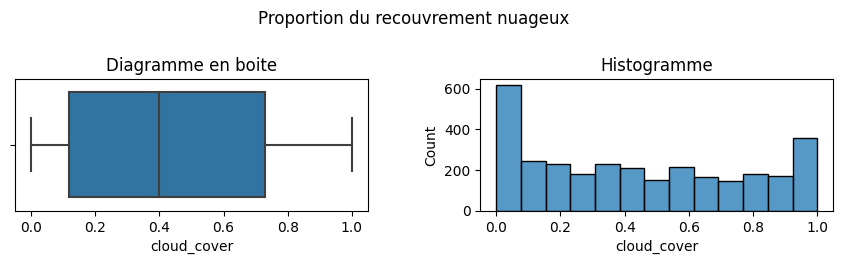

In [19]:
# Il peut ne pas avoir du tout de nuage ou en avoir.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Proportion du recouvrement nuageux")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="cloud_cover", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="cloud_cover", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='moon_phase', ylabel='Count'>

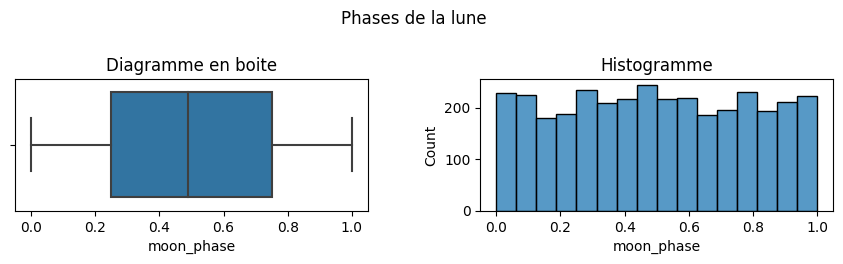

In [20]:
# La phase de la lune importe peu.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Phases de la lune")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="moon_phase", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="moon_phase", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='precip_probability', ylabel='Count'>

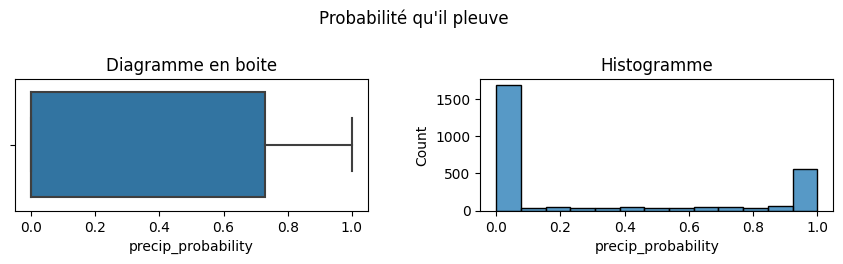

In [21]:
# En général, il ne pleut pas.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Probabilité qu'il pleuve")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="precip_probability", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="precip_probability", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='pressure', ylabel='Count'>

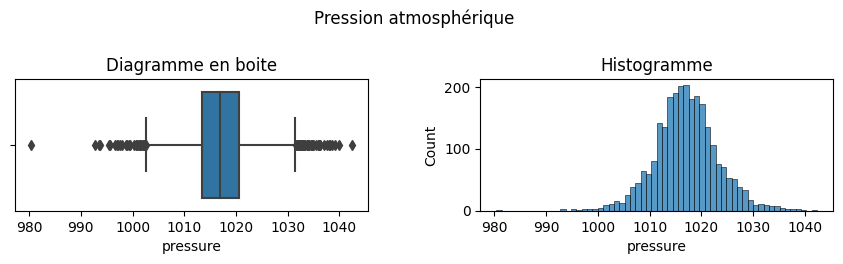

In [22]:
# La distribution est en forme de cloche, plutôt symétrique, c'est caractérstique d'une mesure naturelle.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Pression atmosphérique")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="pressure", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="pressure", data = bigfoot)

<AxesSubplot: title={'center': 'Densité de probabilité'}, xlabel='visibility', ylabel='Density'>

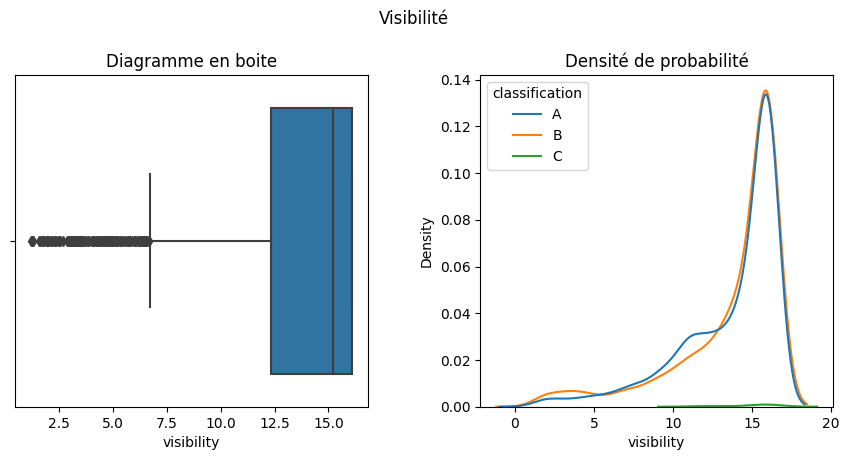

In [23]:
# A très bonne visibilité, class B est à niveau quasiment égal avec la class A et peut même surpasser.
# Il existe des témoignages à moyennes et mauvaise visibilité même s'ils sont moins nombreux. 
# A noter que pour une mauvaise visibilité, il y a tout de même des class A

fig, axes = plt.subplots(ncols = 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
fig.suptitle("Visibilité")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="visibility", data = bigfoot)

axes[1].set_title("Densité de probabilité")
sns.kdeplot(data=bigfoot, x="visibility", hue="classification")

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='wind_bearing', ylabel='Count'>

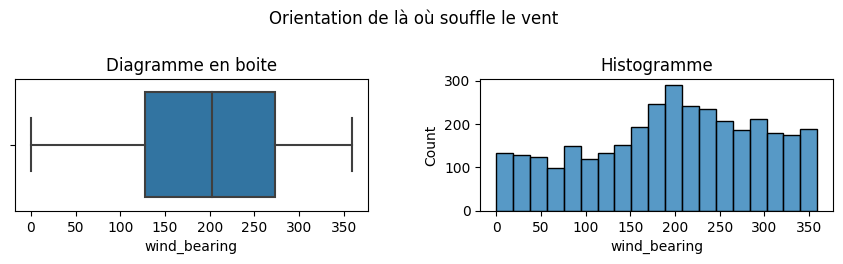

In [24]:
# Plutôt un vent du sud-ouest (environ 200°), moins un vent du nord-est (environ 45°)

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Orientation de là où souffle le vent")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="wind_bearing", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="wind_bearing", data = bigfoot)

<AxesSubplot: title={'center': 'Histogramme'}, xlabel='wind_speed', ylabel='Count'>

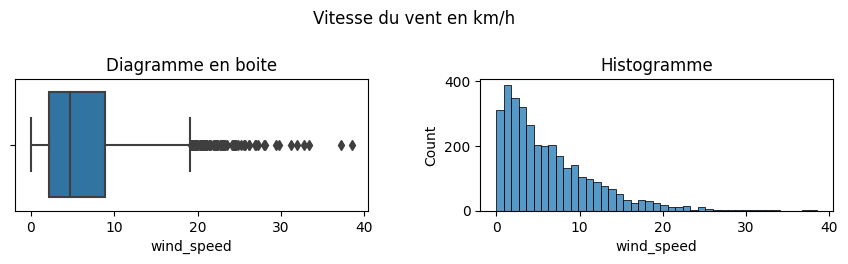

In [25]:
# Globalement un peu de vent.

fig, axes = plt.subplots(ncols = 2, figsize=(10, 3))
fig.tight_layout(pad=5.0)
fig.suptitle("Vitesse du vent en km/h")

axes[0].set_title("Diagramme en boite")
sns.boxplot(ax=axes[0], x="wind_speed", data = bigfoot)

axes[1].set_title("Histogramme")
sns.histplot(ax=axes[1], x="wind_speed", data = bigfoot)

In [26]:
# variables catégorielles

bigfoot.describe(include = "category")

,county,state,season,classification,precip_type
count,5021,5021,4929,5021,1723
unique,1037,49,4,3,2
top,Pierce County,Washington,Summer,B,rain
freq,76,601,1867,2510,1562


In [27]:
"""
class A, class B, class C : class A et B assez équilibrées (2481 et 2510, et 30)

class A = a vu le big foot sans erreur d'interprétation
class B = possiblement
class C = témoignage de faible fiabilité, peu de sources (pris en compte pcq fort potentiel que ces personnes n'aient pas vu le big foot)
"""

bigfoot['classification'].value_counts()

B    2510
A    2481
C      30
Name: classification, dtype: int64

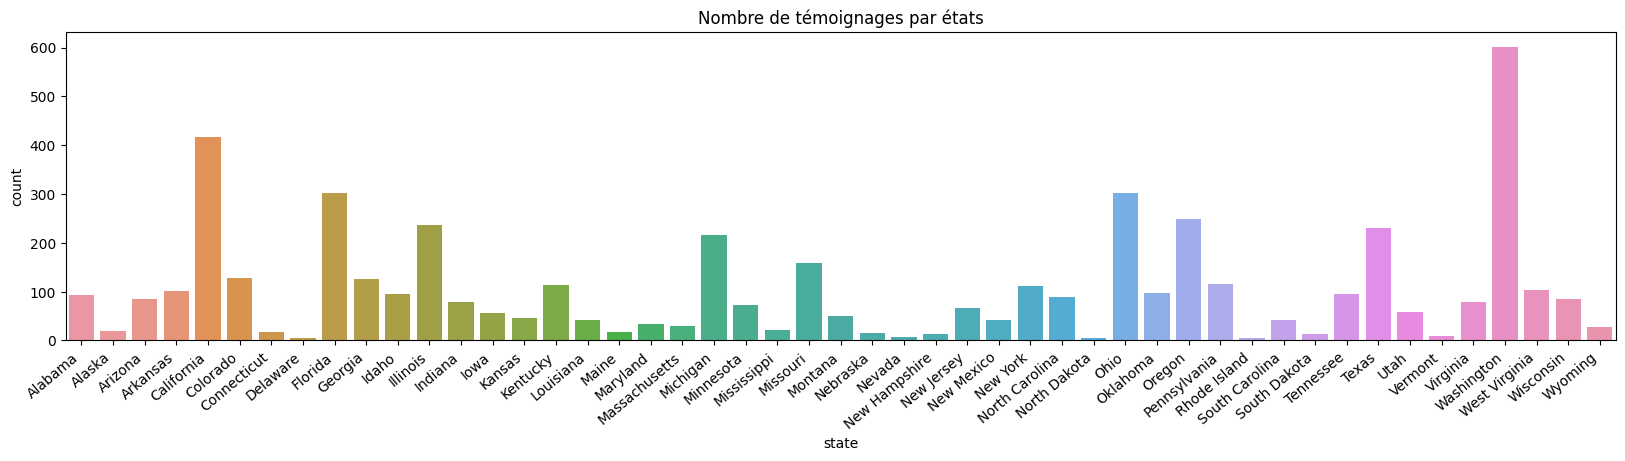

In [28]:
plt.figure(figsize=(20,4))
ax = sns.countplot(x='state', data=bigfoot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Nombre de témoignages par états")
plt.show()

In [29]:
# voir pourquoi on a enlevé les "unknown" pour les saisons car il y en a relativement peu

bigfoot['season'].value_counts()

Summer    1867
Fall      1492
Spring     825
Winter     745
Name: season, dtype: int64

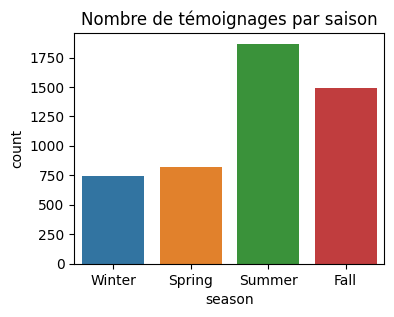

In [30]:
plt.figure(figsize=(4,3))
sns.countplot(x='season', data=bigfoot)
plt.title("Nombre de témoignages par saison")
plt.show()

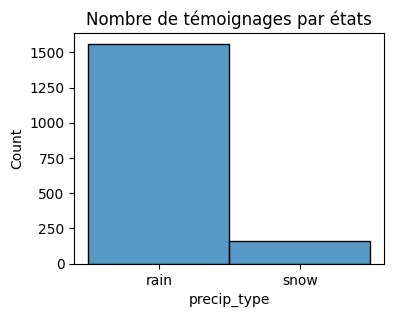

In [31]:
# les précipitations sont en général de la pluie mais il se peut que ce soit de la neige

plt.figure(figsize=(4,3))
sns.histplot(x='precip_type', data=bigfoot)
plt.title("Nombre de témoignages par états")
plt.show()

In [32]:
# variables textuelles

bigfoot.describe(include = "string")

,observed,location_details,title,summary,month
count,4983,4261,4045,3366,4045
unique,4982,4194,4042,321,12
top,I was sitting in my mother's kitchen with 2 of...,(edited),Noon sighting by family of four near Mount Was...,Clear throughout the day.,Oct
freq,2,16,2,754,545


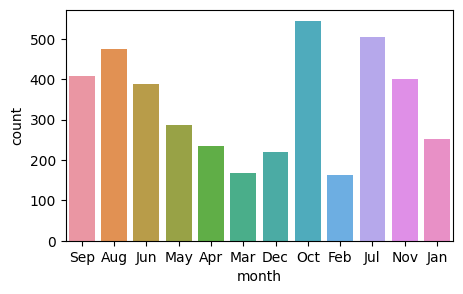

In [33]:
# remarque :  été et pic en octobre (Halloween ?)

plt.figure(figsize=(5, 3))
sns.countplot(x = 'month', data=bigfoot)
plt.show()

In [34]:
# Pour afficher toutes les valeurs prises par toutes les variables

"""
for var in bigfoot.columns:
    print(var + " count : \n" + str(bigfoot[var].value_counts()) + "\n")
"""

'\nfor var in bigfoot.columns:\n    print(var + " count : \n" + str(bigfoot[var].value_counts()) + "\n")\n'

In [35]:
# 5 premiers éléments les plus nombreux par variables

for var in ["state", "county", "summary", "day"]:
    print(var + " count : \n\n" + str(bigfoot[var].value_counts()[:5]) + "\n")

state count : 

Washington    601
California    417
Ohio          303
Florida       302
Oregon        249
Name: state, dtype: int64

county count : 

Pierce County        76
Jefferson County     56
Washington County    54
Snohomish County     51
Lewis County         50
Name: county, dtype: int64

summary count : 

Clear throughout the day.            754
Mostly cloudy throughout the day.    332
Foggy in the morning.                140
Overcast throughout the day.         137
Mostly cloudy until evening.         102
Name: summary, dtype: Int64

day count : 

15    766
1     485
30    133
20    132
14    130
Name: day, dtype: Int64



On remarque que :
* Les états avec le plus de témoignages sont Washington, California, Ohio, Florida.
* Le résumé météo est le plus souvent "Clear throughout the day", suivis de résumé citant des nuages.
* Hypothèse que le 1er et le 15ème du mois (milieu du mois) sont des jours par défaut

### Exploration multivariée

#### Exploration class A et B

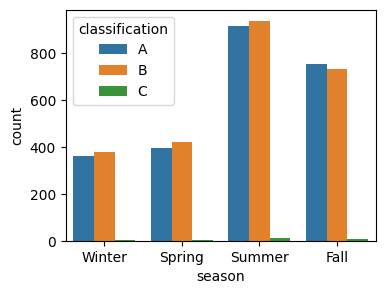

In [36]:
# en fonction des saisons, sensiblement la même proportion de class A et B

plt.figure(figsize=(4,3))
sns.countplot(x='season', hue='classification', data=bigfoot)
plt.show()

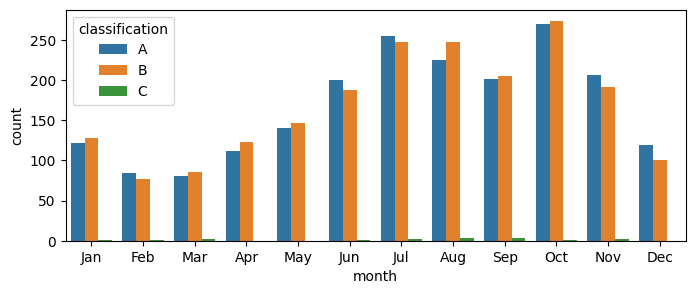

In [37]:
# mais plus en détail, en fonction des mois, il y a plus de class A au début de l'été (juin, juillet) et en début d'hiver (novembre, décembre).
# Plus de class B au milieu du printemps (avril, mai) et del'été (août).

plt.figure(figsize=(8, 3))
sns.countplot(x = 'month', hue='classification', order = months, data=bigfoot)
plt.show()

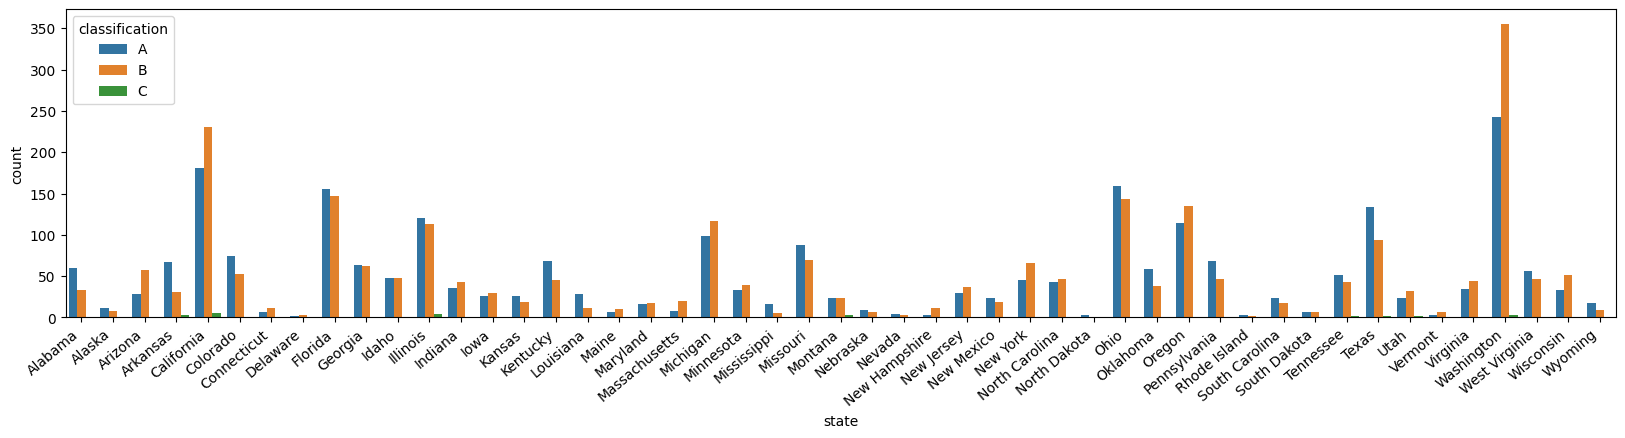

In [38]:
# en fonction des états plus de class A que B
# todo comparer proportions

plt.figure(figsize=(20,4))
ax = sns.countplot(x='state', hue ='classification', data=bigfoot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Dans l'état de Wahshington et Californie, les deux état avec le plus de témoignanges, il y a nettement plus de class B que de class A. Cette différence de proportion est significativement plus importante que dans les autres états. Cela se retrouve aussi en Arizona, dans le Michigan, dans l'état de  New-York, l'Oregon et le Wisconsin.

Les états avec nettement plus de class A sont entre autres l'Alabama, le Kentuckt, le Missouri, l'Ohio, le Texas.

### Analyse multivariée

### Analyse textuelle (à refaire)

In [39]:
rake = Rake(max_length=2, include_repeated_phrases=False)

#rake.extract_keywords_from_text("test")
rake.extract_keywords_from_text(np.stack(bigfoot['observed'])[0])

rake.get_ranked_phrases_with_scores()

#rake.get_word_degrees()

[(4.0, 'weird part'),
 (4.0, 'web site'),
 (4.0, 'practically run'),
 (4.0, 'pacific northwest'),
 (4.0, 'never seen'),
 (4.0, 'last year'),
 (4.0, 'internet search'),
 (4.0, 'important thing'),
 (4.0, 'guy hustle'),
 (4.0, 'even tie'),
 (4.0, 'came frome'),
 (4.0, 'anyone working'),
 (3.666666666666667, 'heard sounded'),
 (3.666666666666667, 'alabama ?"'),
 (3.5, 'woods enough'),
 (3.5, 'whooop ",'),
 (3.5, 'steep hill'),
 (3.5, 'sipsey river'),
 (3.5, 'got dark'),
 (3.5, 'felt like'),
 (3.5, 'area looks'),
 (3.166666666666667, 'ever heard'),
 (3.166666666666667, 'alabama bigfoots'),
 (1.6666666666666667, 'heard'),
 (1.6666666666666667, 'alabama'),
 (1.5, 'woods'),
 (1.5, 'whooop'),
 (1.5, 'river'),
 (1.5, 'like'),
 (1.5, 'hill'),
 (1.5, 'got'),
 (1.5, 'ever'),
 (1.5, 'bigfoots'),
 (1.5, 'area'),
 (1.0, 'wonder'),
 (1.0, 'whoops'),
 (1.0, 'whooops'),
 (1.0, 'whoooop'),
 (1.0, 'well'),
 (1.0, 'watching'),
 (1.0, 'unusual'),
 (1.0, 'trying'),
 (1.0, 'time'),
 (1.0, 'three'),
 (1.0, 'tho

## ACP (Analyse en Composantes Principales) TEST A REFAIRE

prendre en compte jour, mois, saison en les codants avec une valeur numérique.

In [40]:
 bigfoot_nb = bigfoot[
    [
        "latitude",
        "longitude",
        "humidity",
        "cloud_cover",
        "moon_phase",
        "precip_probability",
        "pressure",
        "uv_index",
        "wind_bearing",
        "temperature_high",
        "temperature_mid",
        "temperature_low",
        "dew_point",
        "wind_speed",
        'precip_intensity',
        'visibility',
        'day',
        'month'
    ]
]
bigfoot_nb.dropna(inplace=True)

bigfoot_nb.month = bigfoot_nb.month.map({k: v + 1 for v, k in enumerate(months)})

bigfoot_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2112 entries, 2 to 5013
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            2112 non-null   float64
 1   longitude           2112 non-null   float64
 2   humidity            2112 non-null   float64
 3   cloud_cover         2112 non-null   float64
 4   moon_phase          2112 non-null   float64
 5   precip_probability  2112 non-null   float64
 6   pressure            2112 non-null   float64
 7   uv_index            2112 non-null   Int64  
 8   wind_bearing        2112 non-null   float64
 9   temperature_high    2112 non-null   float64
 10  temperature_mid     2112 non-null   float64
 11  temperature_low     2112 non-null   float64
 12  dew_point           2112 non-null   float64
 13  wind_speed          2112 non-null   float64
 14  precip_intensity    2112 non-null   float64
 15  visibility          2112 non-null   float64
 16  day   

/tmp/ipykernel_10718/4177856676.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigfoot_nb.dropna(inplace=True)
/tmp/ipykernel_10718/4177856676.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigfoot_nb.month = bigfoot_nb.month.map({k: v + 1 for v, k in enumerate(months)})


In [41]:
def scale(data):
    scaler = StandardScaler()
    scaler.fit(data)
    tab = scaler.transform(data)
    return tab

In [42]:
bigfoot_norm = scale(bigfoot_nb)

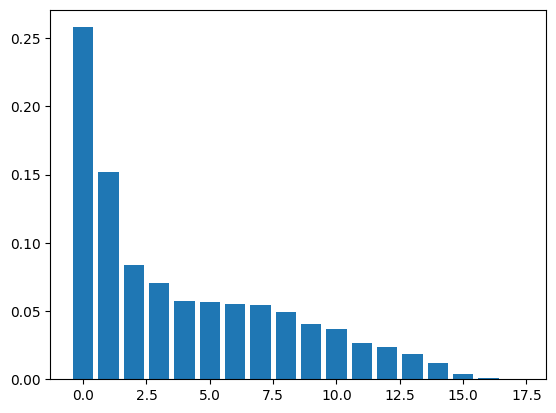

In [43]:
cls = PCA()
pcs = cls.fit_transform(bigfoot_norm)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

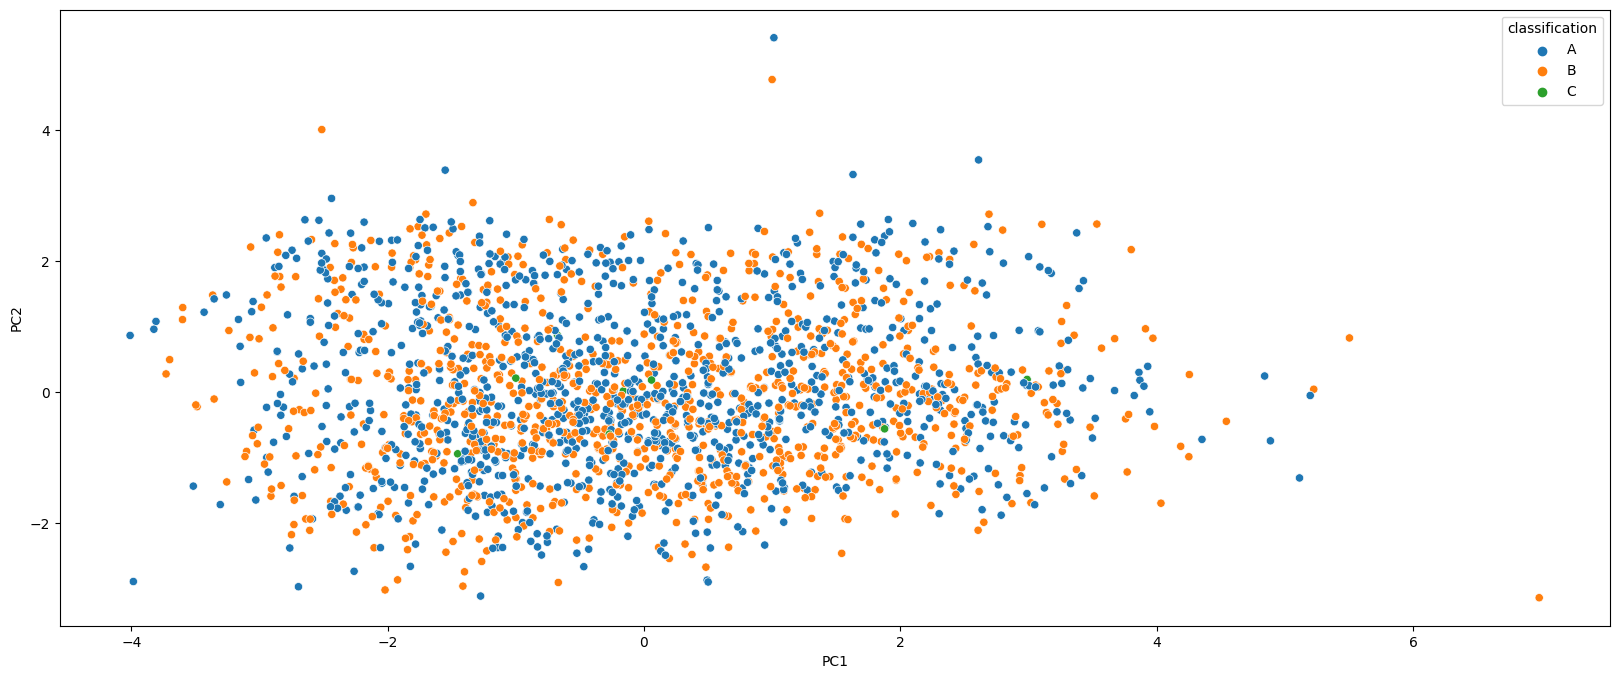

In [44]:
plt.figure(figsize=(20,8))
df_X = pd.DataFrame(pcs, columns=[f"PC{i}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)